In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# [TODO] Define a class which takes system parameters and have a method to generate corresponding graphical objects (Artist) and add them onto given Axes object etc. This class would make the code seems clean make it easy to manage

# [DONE] Test drawing primitive artist objects
Examples include `Rectangle`, `Circle` etc. in `matplotlib.patches` module

# Define system parameters

In [2]:
num_of_masses = 5
num_of_main_box = 1
num_of_ball = num_of_masses - num_of_main_box

In [3]:
masses = np.ones(num_of_masses) * 10
m = masses  # aliasing
spring_constants = np.ones(num_of_ball) * 50.0
k = spring_constants  # aliasing

In [4]:
x_min, x_max = -10, 10
y_min, y_max = 0, 5

box_width = 7

assert box_width < x_max - x_min

In [5]:
box_height = y_max - y_min

In [6]:
ball_radius = box_height / num_of_ball * 0.5

In [7]:
pad_factor = 0.1
data_width = x_max - x_min
pad_width = data_width * pad_factor
data_height = y_max - y_min
pad_height = data_height * pad_factor

x_lim = (x_min - pad_width, x_max + pad_width)
y_lim = (y_min - pad_height, y_max + pad_height)

# Solve ODE

### Initial values

In [8]:
x_box_center_in_box = 0.0
x_box_center_in_rail = 0.1

x_balls_in_box = np.empty(num_of_ball)
x_balls_in_box[:] = (np.random.rand(num_of_ball) - 0.5) * 2.0 * (0.5 * box_width - ball_radius)
x_balls_in_rail = x_balls_in_box + x_box_center_in_rail

In [9]:
initial_vector = [0] * num_of_masses * 2
initial_vector[0::2] = [x_box_center_in_rail, *x_balls_in_box]  # initialize positions
velo_mag = 1.0
initial_vector[1::2] = 2.0 * (np.random.rand(num_of_masses) - 0.5) * velo_mag

In [10]:
from scipy.integrate import ode

In [11]:
def get_dydt(t, y, k, m):
    assert len(y) % 2 == 0
    assert len(y) >= 4
    #print('k: {0} / tf: {1}'.format(k, isinstance(k, np.ndarray)))
    dydt = [0] * len(y)  # initialization
    x_balls_in_box = np.array(y[2::2])
    assert isinstance(k, np.ndarray)
    assert isinstance(m, np.ndarray)
    assert len(k) == len(x_balls_in_box)
    assert len(k) == len(m) - 1
    ma0 = (x_balls_in_box * k).sum()
    dydt[0::2] = y[1::2]  # diff of no dot == single dot
    dydt[1] = ma0 / m[0]
    #print("dd",(k * x_balls_in_box - ma0) / m[1:])
    dydt[3::2] = - (k * x_balls_in_box + ma0) / m[1:]
    return dydt

fargs = (k,m)

In [12]:
get_dydt(10, initial_vector, k, m)

[-0.009594703460782172,
 -1.1485043318561268,
 0.14772446187282307,
 13.803967021973687,
 -0.08627032245345911,
 -6.21344137858401,
 0.5027454741026665,
 1.590106473845961,
 -0.76284323403945,
 -3.4381104579550055]

In [28]:
solver = ode(get_dydt)

solver.set_integrator('dopri5', nsteps=10000)

solver.set_f_params(*fargs)

solver.set_initial_value(initial_vector)

sol = []
solver.set_solout(lambda t, y: sol.append((t,*y)))

In [29]:
solver.integrate(1000)

/home/seongjin/HazaPython/venv01/lib/python3.5/site-packages/scipy/integrate/_ode.py:1095: UserWarning: dopri5: larger nmax is needed
  self.messages.get(istate, unexpected_istate_msg)))


array([-22.27221173,  -0.2815737 ,  -1.79697172,   4.10709079,
         1.12948967,  -2.00618222,   0.13631487,   0.74951366,
         0.51341828,  -1.68917087])

Text(0,0.5,'amplitude')

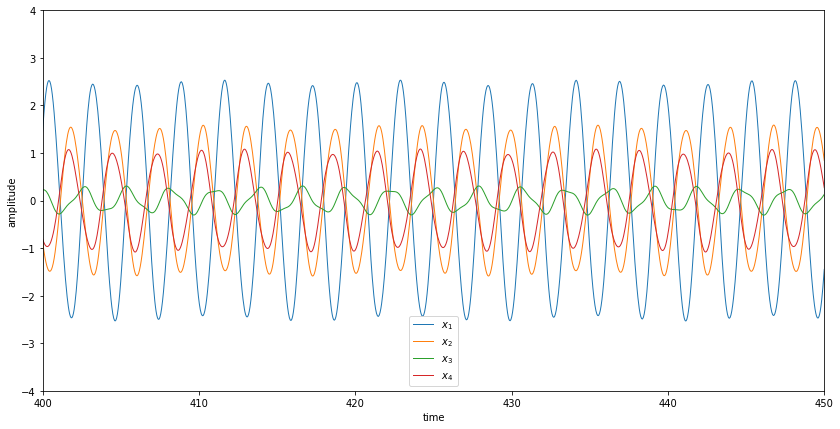

In [31]:
figg, axx = plt.subplots(figsize=(14,7))
t = None
for idx, ydata in enumerate(zip(*sol)):
    if idx == 0:
        t = ydata
        continue
    if idx % 2 == 0: continue
    if idx <= 2: continue
    axx.plot(t,ydata, label='$x_{{{0}}}$'.format((idx // 2)), linewidth=1.0)
axx.legend()
#axx.set_ylim(*x_lim)
axx.set_ylim(-4,4)
axx.set_xlim(400,450)

axx.set_xlabel('time')
axx.set_ylabel('amplitude')

In [32]:
#figg.savefig('doesnt seem to synchronize 02.png')

# Construct Artist objects

### Bounding lines

In [17]:
from matplotlib.lines import Line2D

In [18]:
bounding_line_kwargs = {'color':'black'}
lower_line = Line2D([x_min, x_max], [y_min, y_min], **bounding_line_kwargs)
upper_line = Line2D([x_min, x_max], [y_max, y_max], **bounding_line_kwargs)

lines = [lower_line, upper_line]

### Main box

In [19]:
from matplotlib.patches import Rectangle

In [20]:
lower_left_xy_coord = (x_box_center_in_rail - box_width * 0.5, y_min)
main_box = Rectangle(lower_left_xy_coord, box_width, box_height, facecolor='white', edgecolor='black')

### Balls

In [21]:
from matplotlib.patches import Circle

In [22]:
y_balls_in_rail = np.arange(num_of_ball) * ball_radius * 2.0 + ball_radius

circle_centers = zip(x_balls_in_rail, y_balls_in_rail)

In [23]:
circle_properties = {'facecolor':'white', 'edgecolor':'black'}
circles = []
for center_xy in circle_centers:
    cir = Circle(center_xy, radius=ball_radius, **circle_properties)
    circles.append(cir)

### Stairs

In [24]:
stairs = []

if num_of_ball > 1:
    stair_height = ball_radius * 2.0
    y_stairs = np.arange(num_of_ball - 1) * stair_height + stair_height
    x_data = [x_box_center_in_rail - box_width * 0.5, x_box_center_in_rail + box_width * 0.5]
    for y_value in y_stairs:
        line = Line2D(x_data, [y_value, y_value], color='black')
        stairs.append(line)

# Draw Artist objects

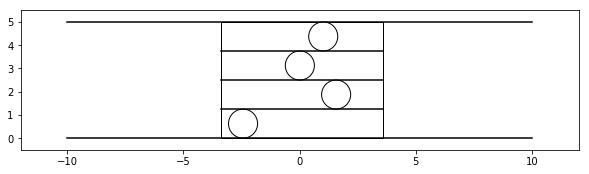

In [25]:
fig, ax = plt.subplots(figsize=(10,7))

ax.axis('square')
ax.set_xlim(*x_lim)
ax.set_ylim(*y_lim)

for line in lines: ax.add_line(line)

ax.add_patch(main_box)
for circle in circles: ax.add_patch(circle)

for line in stairs: ax.add_line(line)

In [26]:
#fig.savefig('graffiti-of-system.png')